# 🌱 Introduction - Let's Crack Fertilizer Prediction 🚀

"""
Hey there! 👋

Welcome to my notebook for the June 2025 Kaggle Playground competition — and this time we’re predicting the **best fertilizers** for different types of crops under various soil and weather conditions. Sounds cool, right? 😄

🧠 The main idea is simple: 
Based on features like temperature, rainfall, humidity, soil type, and crop type, we want to tell farmers which fertilizers will work best. And not just one — Kaggle wants us to predict **top 3** fertilizer names that fit the situation. So yeah, it’s a multi-label ranking problem 🔢.


### 📌 What you’ll find in this notebook:
I'm going to walk you through my entire approach step by step:
1. First, we’ll load and clean the data 🧹  
2. Then we’ll do a quick EDA to get a feel for things 📊  
3. After that, some preprocessing and maybe a little PCA for fun  
4. Finally, we’ll train XGBoost / LightGBM models and prepare a nice clean submission 💥

Stay tuned, let’s grow this solution like a crop 🌾 (pun intended 😄)!
"""


In [1]:
# 🌟 Let's get started — sabse pehle required libraries ko import karte hain!

import numpy as np
import pandas as pd
import gc
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display            # for head()

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler  # scaler optional (future)
from sklearn.decomposition import PCA                              # optional (future)
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb

warnings.simplefilter(action='ignore')

# ============================================
# 📦 1) House-keeping & common settings
# ============================================
SEED   = 13
TARGET = "Fertilizer Name"          
np.random.seed(SEED)


In [2]:
# ============================================
# 📥 2) Load data
# ============================================
train_df     = pd.read_csv("/kaggle/input/playground-series-s5e6/train.csv")
test_df      = pd.read_csv("/kaggle/input/playground-series-s5e6/test.csv")
submission   = pd.read_csv("/kaggle/input/playground-series-s5e6/sample_submission.csv")
original_df  = pd.read_csv("/kaggle/input/fertilizer-prediction/Fertilizer Prediction.csv")

# Fix common typo once
for df in (train_df, test_df, original_df):
    df.rename(columns={"Temparature": "Temperature"}, inplace=True)

# 👉 Make working copies for feature-engineering
train    = train_df.copy()
test     = test_df.copy()
original = original_df.copy()

print("✅ Datasets loaded and initial typo fixed!")

✅ Datasets loaded and initial typo fixed!


🔍 Doing a little EDA before jumping into modeling...
📝 Train Data Sample:


,id,Temperature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,1,27,69,65,Sandy,Millets,30,6,18,28-28
2,2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,4,35,58,43,Red,Paddy,37,2,16,DAP


📐 Shape of train: (750000, 10)
📐 Shape of test: (250000, 9)
📐 Shape of external/original data: (100000, 9)

❓ Checking missing values:
id                 0
Temperature        0
Humidity           0
Moisture           0
Soil Type          0
Crop Type          0
Nitrogen           0
Potassium          0
Phosphorous        0
Fertilizer Name    0
dtype: int64

🧪 Unique Fertilizer Labels:
Fertilizer Name
14-35-14    114436
10-26-26    113887
17-17-17    112453
28-28       111158
20-20       110889
DAP          94860
Urea         92317
Name: count, dtype: int64


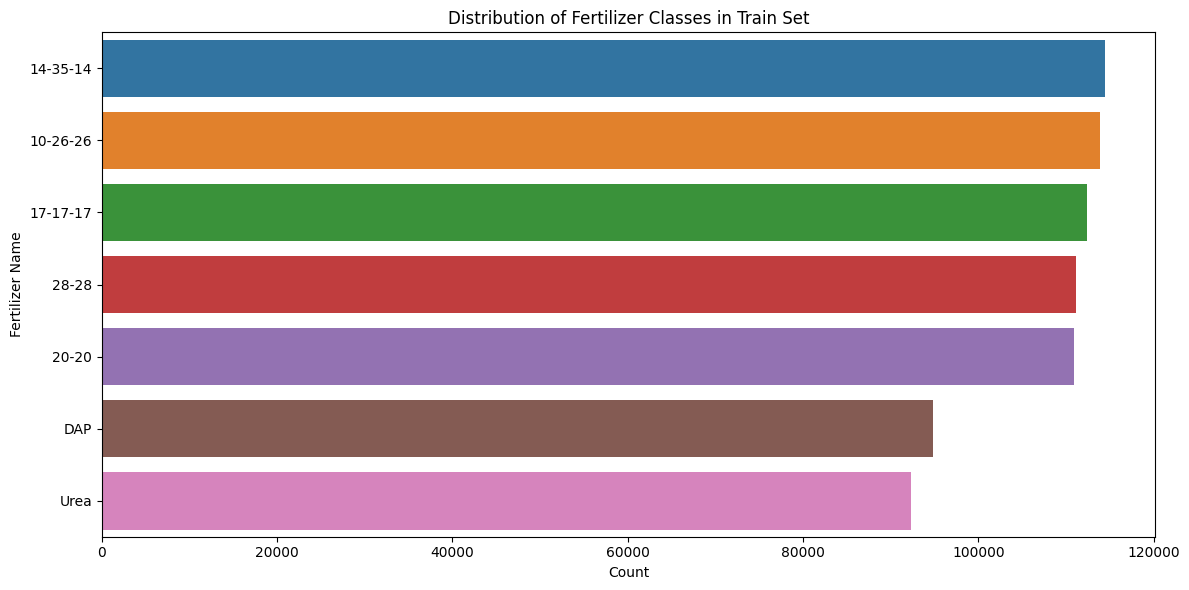

In [3]:
# ============================================
# 👀 Quick EDA — Data se dosti karte hain pehle 🤝
# ============================================

print("🔍 Doing a little EDA before jumping into modeling...")

# 1️⃣ Let's see how our training data looks
print("📝 Train Data Sample:")
display(train_df.head())

print("📐 Shape of train:", train_df.shape)
print("📐 Shape of test:", test_df.shape)
print("📐 Shape of external/original data:", original_df.shape)

# 2️⃣ Check if any columns have missing values
print("\n❓ Checking missing values:")
print(train_df.isnull().sum())

# 3️⃣ Unique fertilizer labels — ye hi to predict krna hai 🎯
print("\n🧪 Unique Fertilizer Labels:")
print(train_df['Fertilizer Name'].value_counts())

# 4️⃣ Plot — Target distribution (thoda imbalance ho to pata chale)
plt.figure(figsize=(12, 6))
sns.countplot(data=train_df, y='Fertilizer Name', order=train_df['Fertilizer Name'].value_counts().index)
plt.title("Distribution of Fertilizer Classes in Train Set")
plt.xlabel("Count")
plt.ylabel("Fertilizer Name")
plt.tight_layout()
plt.show()


In [4]:
# ============================================
# 🔧 4) Add numeric→categorical “_Binned” wrappers
# ============================================
def add_catfeatures(df, numeric_cols):
    """Har numeric col ka ek categorical duplicate (_Binned) banata hai."""
    for col in numeric_cols:
        if col in df.columns:           # guard if external lacks it
            df[f"{col}_Binned"] = df[col].astype("category")
    return df

num_cols = [c for c in train.select_dtypes(exclude=["object", "category"]).columns]
for df in (train, test, original):
    add_catfeatures(df, num_cols)



In [8]:
# ============================================
# 🔢 5) Label-encode ALL categoricals (shared mapping)
# ============================================
cat_cols = [
    c for c in train.select_dtypes(include=["object", "category"]).columns
    if c != TARGET and c in test.columns and c in original.columns]


encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    le.fit(pd.concat([train[col], test[col], original[col]]).astype(str))
    encoders[col] = le
    for df in (train, test, original):
        df[col] = pd.Series(le.transform(df[col].astype(str)), index=df.index).astype("category")

In [11]:
# ============================================
# 🎯 6) Encode target
# ============================================
target_le = LabelEncoder()
target_le.fit(pd.concat([train[TARGET], original[TARGET]]))
train[TARGET]    = target_le.transform(train[TARGET])
original[TARGET] = target_le.transform(original[TARGET])   # external may aid future ensembling

In [12]:
# ============================================
# 🏗️ 7) Final feature list
# ============================================
features = [
    c for c in train.columns
    if c != TARGET and c in test.columns and c in original.columns
]

bad_cols = []
for c in features:
    combined = pd.concat([train[c], test[c], original[c]])
    if combined.nunique() == 1:         # constant in ALL sets
        bad_cols.append(c)

features = [c for c in features if c not in bad_cols]

print(f"📊 Using {len(features)} features (dropped {len(bad_cols)})")


📊 Using 14 features (dropped 0)


In [14]:
# 🤖 Model Training — Stack bana rahe hain modelon ka 🧱

print("📦 Preparing data for training...")

#  Split features and labels from train + test + original
X = train.drop(columns=[ "Fertilizer Name"])
y = train["Fertilizer Name"].astype(int)

X_test = test.drop(columns=["id"])
X_original = original.drop(columns=["id", "Fertilizer Name"])
y_original = original["Fertilizer Name"].astype(int)


print("X and Y created")

📦 Preparing data for training...


KeyError: "['id'] not found in axis"

In [ ]:
# 🔧 XGBoost ke best parameters

xgb_params =
    'max_depth': 8,
    'max_bins': 128,
    'learning_rate': 5e-2,
    'min_child_weight': 2,
    'alpha': 6.5,
    'reg_lambda': 5.3,
    'subsample': 0.8,
    'colsample_bytree': 0.3,
    'tree_method': 'hist',  
    'device': "cuda"
} {
    'objective'        :'multi:softprob',
    'num_class'        : y.nunique(),


# 🧠 MAP@3 custom metric
def mapk(actual, predicted, k=3):
    def apk(a, p, k):
        p = p[:k]
        score = 0.0
        hits = 0
        seen = set()
        for i, pred in enumerate(p):
            if pred in a and pred not in seen:
                hits += 1
                score += hits / (i + 1.0)
                seen.add(pred)
        return score / min(len(a), k)
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])


In [ ]:
# 🎯 Folds barha kar 10 kar diye hain for better generalization
FOLDS = 10
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

# 🔄 Predictions ko hold karne ke liye
num_classes = y.nunique()
oof = np.zeros((len(train), num_classes))
pred_prob = np.zeros((len(test), num_classes))
map3_scores = []

# 🔁 CV loop
for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    print(f"\n📚 Fold {fold+1}/{FOLDS} training...")

    x_train, x_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # 📌 External original data se augment karo
    x_train = pd.concat([x_train, X_original], ignore_index=True)
    y_train = pd.concat([y_train, y_original], ignore_index=True)

    model = XGBClassifier(**xgb_params)

    model.fit(
        x_train,
        y_train,
        eval_set=[(x_train, y_train), (x_valid, y_valid)],
        early_stopping_rounds=50,
        verbose=1000
    )

    evals_result = model.evals_result()
    val_loss = evals_result['validation_1']['mlogloss']
    plt.plot(val_loss, label=f"Fold {fold+1}")

    # 🧪 Validation Predictions
    oof[valid_idx] = model.predict_proba(x_valid)
    pred_prob += model.predict_proba(X_test) / FOLDS

    # 🎯 MAP@3 for this fold
    top_3_preds = np.argsort(oof[valid_idx], axis=1)[:, -3:][:, ::-1]
    actual = [[label] for label in y_valid]
    map3_score = mapk(actual, top_3_preds)
    map3_scores.append(map3_score)
    print(f"✅ Fold {fold+1}: MAP@3 = {map3_score:.5f}")

    gc.collect()

# 📊 Final Log Loss Plot
plt.title("Validation Log Loss per Fold")
plt.xlabel("Boosting Rounds")
plt.ylabel("Log Loss")
plt.legend()
plt.grid(True)
plt.show()

# 📈 Aggregate Metrics
print("\n📌 Average MAP@3:", np.mean(map3_scores))
y_true = y.values
y_pred = np.argmax(oof, axis=1)
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred))
print("\n📊 Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

try:
    roc_auc = roc_auc_score(y_true, oof, multi_class='ovr', average='macro')
    print(f"\ud83c\udfc5 ROC AUC (macro): {roc_auc:.4f}")
except:
    print("\u26a0\ufe0f ROC AUC couldn't be calculated.")


In [ ]:
# Final Step — Let’s create our submission file! 

print("\n Creating final submission file...")

# Sabse top 3 predictions nikalte hain har row ke liye
# Argsort: sabse high probability wale class indices ko descending order me la raha hai
top_3_preds_indices = np.argsort(final_test_preds, axis=1)[:, ::-1][:, :3]

#  Refit target encoder on original string labels (as safety — taake inverse_transform sahi kaam kare)
target_encoder.fit(train_df['Fertilizer Name'].unique())

#  Convert predicted indices back into fertilizer name strings
top_3_labels = target_encoder.inverse_transform(top_3_preds_indices.ravel()).reshape(top_3_preds_indices.shape)

#  Combine predictions into space-separated string per row
submission['Fertilizer Name'] = [' '.join(row) for row in top_3_labels]

#  Save the submission file
submission.to_csv('submission_lean_stack.csv', index=False)

print(" Lean Stacking submission saved successfully!" )
print(submission.head())


# ✅ Conclusion — And That’s a Wrap! 🚀

"""
Thanks for sticking around till the end! 🙌

In this notebook, we went from raw CSVs to a full-blown stacked ensemble pipeline 🧱
Here’s a quick recap of what we did:

So what’s next? 🤔
- Try tuning hyperparameters (learning rate, depth, leaves etc.)
- Experiment with more features from external datasets
- Test CatBoost as a 3rd base model in the stack
- Try transformer-based tabular models like TabNet or SAINT 🔥
- Explore label correlations (some fertilizers often occur together)

💬 Let me know if you fork this and try something cool — I’d love to see what you build!

Until next time — may your models be accurate and your kernels reproducible 😄  
"""

-----------

# 💬 Let's Connect — I’d Love to Hear from You! 🌍✨

"""
Thanks for checking out my notebook! 😊

If you found this helpful, learned something new, or even if you have a better idea (I’m always open to learning!) — let’s chat!  
I’d really appreciate your feedback, suggestions, or just a friendly hello 👋

📬 You can reach me here:
- 📌 Kaggle: https://www.kaggle.com/sheemamasood
- 💼 LinkedIn: https://www.linkedin.com/in/sheema-masood/
- 📧 Email: sheemamasood381@gmail.com

Also, feel free to fork this notebook and tag me if you do something cool with it! 🔥  
Let’s grow and build awesome things together. 🚀

#AI #MachineLearning #Kaggle #FertilizerPrediction #Stacking #XGBoost #LightGBM #OpenToCollab
"""
